### Analysis of PDOP and Jammer Datasets
This notebook demonstrates how to load, access, and analyze the "pdop" and "jammer" datasets, which are used in the evaluation section of our paper. The datasets are stored as CSV files and contain timing, diagnostics and meta information acquired from UWB transceivers. The columns used in the dataset are described in the table below.

| Col. name             | Description                                                    | Example                           |
|-----------------------|----------------------------------------------------------------|-----------------------------------|
| _time                 | ISO datetime of ranging cycle                                  | "2023-05-02T19:38:00.95351Z"      |
| seqcode               | Unique for experiment(*)                                       | 0, 1381126738                     |
| seqno                 | Identifier of ranging sequence                                 | 1, 2, 3, ...                      |
| nodeid                | Identifier of anchor node                                      | "21", "22", ...                   |
| arx1                  | RX timestamp of packet a (units of 15.65ps)                    | 126327522454                      |
| arx2                  | RX timestamp of packet c (units of 15.65ps)                    | 126557619189                      |
| atx1                  | TX timestamp of packet b (units of 15.65ps)                    | 126429823816                      |
| trx1                  | RX timestamp of packet b (units of 15.65ps)                    | 561830338362                      |
| ttx1                  | TX timestamp of packet a (units of 15.65ps)                    | 561728036864                      |
| ttx2                  | TX timestamp of packet c (units of 15.65ps)                    | 561958133248                      |
| dist_correction       | Distance correction for node-anchor pairing in m               | 0.86                              |
| cir_arx1              | Channel impulse response of packet a (base64 coded)            | QwBR...Ag==                       |
| cir_arx2              | Channel impulse response of packet c (base64 coded)            | HgAa...AQ==                       |
| cir_trx1              | Channel impulse response of packet b (base64 coded)            | QABF...Ag==                       |
| cqarx1                | Diagnostics data (base64 coded)                                | QAou...CxkN                       |
| cqarx2                | Diagnostics data (base64 coded)                                | +wWT...khgN                       |
| cqtrx1                | Diagnostics data (base64 coded)                                | CgVc...WxgN                       |
| dt_arx1               | ML-based confidence of packet a                                | 0.629                             |
| dt_arx2               | ML-based confidence of packet c                                | 0.601                             |
| dt_trx1               | ML-based confidence of packet b                                | 0.641                             |
| mlbased               | ML-based trustworthiness indicator                             | 0.641                             |
| pos_x                 | Position of anchor #nodeid (x component)                       | 0.01                              |
| pos_y                 | Position of anchor #nodeid (y component)                       | 2.45                              |
| distance_ground_truth | Ground truth distance to anchor node (jammer scenario)         | 1.53                              |


(*) A ranging sequence is uniquely identified by the tuple [seqcode, seqno], a ranging cycle by [seqcode, seqno, nodeid].

**First import required packages**

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import struct
import base64

**Define algorithms**
for localization and to extract channel impulse response and diagnostics information from base64 encoded representation
Diagnostics information are further described in the [DW1000 User Manual](https://www.qorvo.com/products/d/da007967) (see registers 0x12 and 0x15).

In [12]:
def localize_llsq(A, d):
        t = np.multiply(A,A) @ np.array([[1], [1]])
        Dsquared = np.multiply(d,d)
        h = t[:-1]-Dsquared[:-1]-np.ones([len(t)-1, 1])*(t[-1]-Dsquared[-1])
        E = 2*(A[:-1,:] - A[-1, :])
        x = np.linalg.inv(E.T @ E) @ E.T @ h
        return x

def extract_cq(cq_str):
    if type(cq_str) == str:
        keys   = ["FPAmpl1", "FPAmpl2", "FPAmpl3", "CIRPwr", "STDNoise", "RXPACC", "FPIndex", "LDETresh", "LDEPPindx", "LDEPPampl", "NTM"]
        values = struct.unpack("=10HB", base64.b64decode(cq_str))
        return {k : values[i] for i, k in enumerate(keys)}
    if type(cq_str) == list:
        return list(map(extract_cq, cq_str))
    
def extract_abs_cir(cir_str, cir_len=50):
    if type(cir_str) == str:
        return struct.unpack(f"={cir_len}H", base64.b64decode(cir_str))
    if type(cir_str) == list:
        return list(map(extract_abs_cir, cir_str))


**Read in csv file, extract data and estimate positions**

In [13]:
data = pd.read_csv('jammer.csv', header=3) # here also pdop.csv can be used!

seqno = np.unique(data['seqno'].to_numpy()) # get 
anchor_ids = np.unique(data['nodeid'].to_numpy())


sequences = []

for i, seq in enumerate(seqno):
    d = data[data['seqno'] == seq] # sequence by sequence
    
    sequence_data = { # dict for result
        "node" : [],
        "estpos" : np.zeros([0, 2]),
        "seqno" : seq
    }   
    
    nodeids = d['nodeid'].to_numpy()
    for nodeid in nodeids:
        anchor = d[d['nodeid'] == nodeid] # process node by node

        Rt = anchor["trx1"].squeeze() - anchor["ttx1"].squeeze()
        Da = anchor["atx1"].squeeze() - anchor["arx1"].squeeze()
        Ra = anchor["arx2"].squeeze() - anchor["atx1"].squeeze()
        Dt = anchor["ttx2"].squeeze() - anchor["trx1"].squeeze()
        
        tof = (Ra*Rt-Da*Dt) / (2.0 * (Ra + Da)) * 15.65 / 1000000000000.0 # estimate time of flight
        dist = 300000000.0*tof - anchor['dist_correction'].squeeze() # multiply by speed of light to get distance estimate
        
        pos = [anchor["pos_x"].squeeze(), anchor["pos_y"].squeeze()]
        mtime = anchor['_time'].squeeze()

        # encoded channel impulse response
        cir_arx1_enc = anchor['cir_arx1'].squeeze()
        cir_trx1_enc = anchor['cir_trx1'].squeeze()
        cir_arx2_enc = anchor['cir_arx2'].squeeze()
        
        
        # decode channel impulse response
        cir_arx1 = extract_abs_cir(cir_arx1_enc) # shared by anchor
        cir_trx1 = extract_abs_cir(cir_trx1_enc) # locally
        cir_arx2 = extract_abs_cir(cir_arx2_enc) # shared by anchor
        
        cirs = { # decoded channel impulse responses
            'cir_arx1' : cir_arx1,
            'cir_trx1' : cir_trx1,
            'cir_arx2' : cir_arx2  
        }
        
        # append double-sided two-way ranging result for node
        sequence_data["node"].append({'pos': pos, 'dist': dist, 'nodeid': int(nodeid), 'cirs' : cirs})
    
        
    A = np.array([seq['pos'] for seq in sequence_data["node"]]).reshape([-1, 2]) # matrix representation of anchor positions
    D = np.array([seq['dist'] for seq in sequence_data["node"]]).reshape([-1, 1])# vecotr representation of distance estimates
    
    try:
        x = localize_llsq(A, D).reshape(-1) # get position estimate
        sequence_data["estpos"] = x         # store result
        
        
    except np.linalg.LinAlgError:
        continue 
    
    sequences.append(sequence_data)  # collect results of all sequences

/tmp/ipykernel_1312/1562828832.py:27: RuntimeWarning: overflow encountered in long_scalars
  tof = (Ra*Rt-Da*Dt) / (2.0 * (Ra + Da)) * 15.65 / 1000000000000.0 # estimate time of flight


**Plot estimated positions**

Text(0.5, 1.0, 'Position estimates')

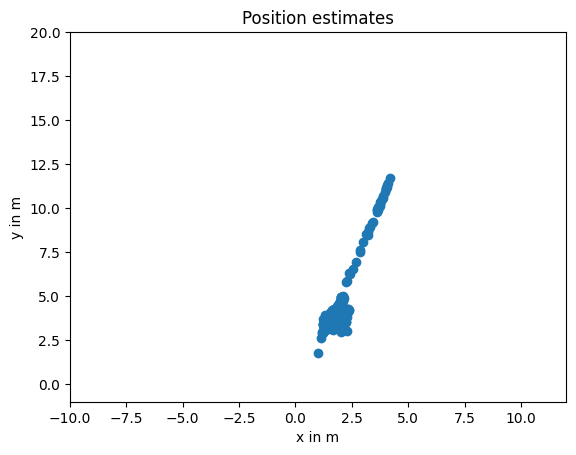

In [14]:
seq = [s['seqno'] for s in sequences]               # extract sequence numbers
pos = np.array([s['estpos'] for s in sequences])    # extract estimated positions

# Plot estimated positions
plt.figure()
plt.scatter(pos[:, 0], pos[:, 1])
plt.xlim([-10, 12])
plt.ylim([-1, 20])

plt.xlabel("x in m")
plt.ylabel("y in m")
plt.title("Position estimates")

**Plot exemplary channel impulse response**

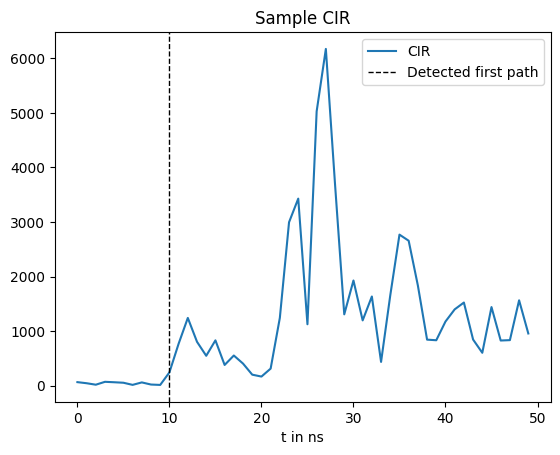

In [18]:
seq = [s['seqno'] for s in sequences]
pos = np.array([s['estpos'] for s in sequences])

rseq = np.random.randint(0, len(sequences))
nodes = sequences[rseq]["node"]
rnode = np.random.randint(0, len(nodes))
node = nodes[rnode]

cir = node["cirs"]["cir_trx1"]

plt.figure()
plt.plot(cir, label="CIR")

# 50 absolute CIR samples are collected (10 before and 40 after the detected first path)
plt.axvline(10, label="Detected first path", linewidth=1, linestyle="--", color="k") 

plt.xlabel("t in ns")
plt.title("Sample CIR")

plt.legend()